# Marker Genes Calculation and Visualization

## Loading Packages

In [45]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append(r'../../../')
from Model.preprocess import fix_seed, preprocessing, replace_extreme_values
from Model.utils import rotate_spatial_coordinates, reorder_categories
fix_seed(2024)

## Loading Data

In [9]:
slice_id = 4    ## 1, 2, 3, 4

slice_name = ['ATAC', 'H3K4me3', 'H3K27ac', 'H3K27me3']

adata_modality_1 = sc.read_h5ad(f"../../../Data/Mouse_Brain_{slice_name[slice_id-1]}/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad(f"../../../Data/Mouse_Brain_{slice_name[slice_id-1]}/adata_peaks_normalized.h5ad")
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'Spatial-epigenome-transcriptome')

adata_results = sc.read_h5ad(f"../../Mouse_Brain_{slice_name[slice_id-1]}.h5ad")

Spatial-epigenome-transcriptome data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (9732, 3000)
Dimensions after preprocessing adata_modal_2: (9732, 70470)


## Calculating Marker Genes

In [10]:
adata_modality_1.obs['SpaKnit'] = adata_results.obs['SpaKnit']

## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='SpaKnit')
sc.tl.rank_genes_groups(adata_modality_1, groupby='SpaKnit', use_raw=False)

## store the results
rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
rank_genes.to_excel(f"{slice_name[slice_id-1]}/Marker_Genes.xlsx", index=True)

## Ploting Spatial Distribution of Marker Genes

Processing slice: ATAC


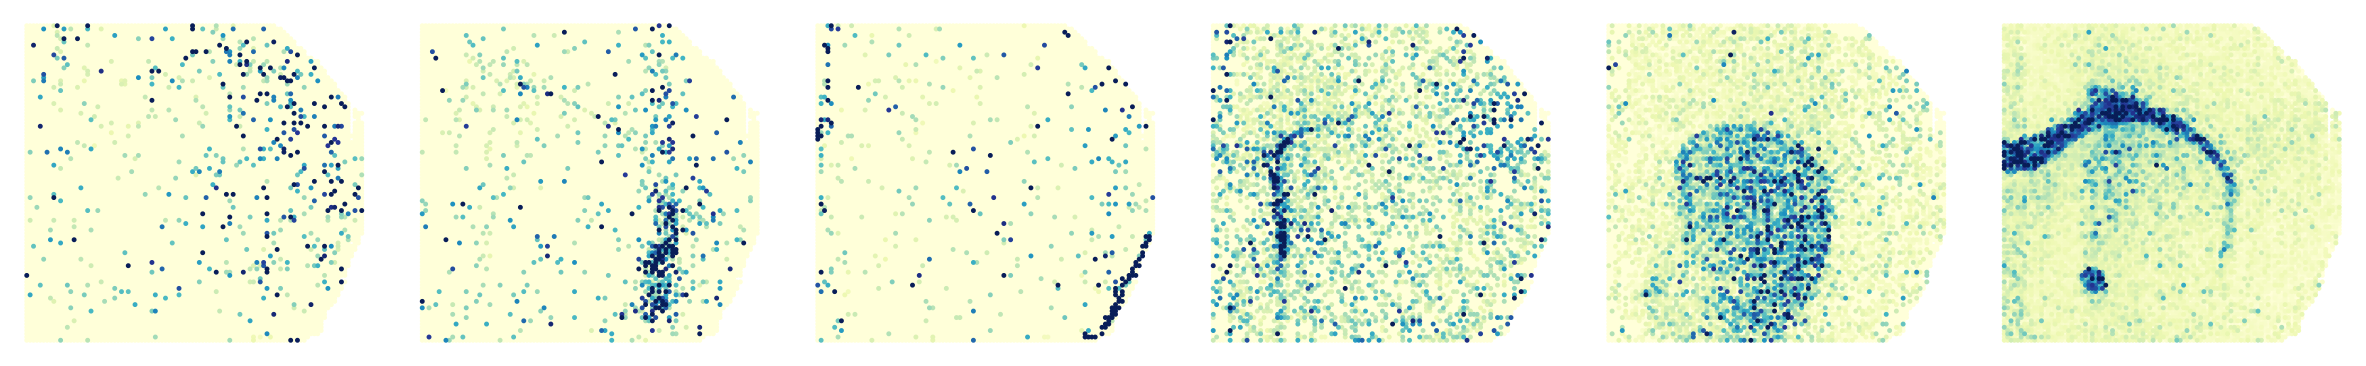

Processing slice: H3K4me3


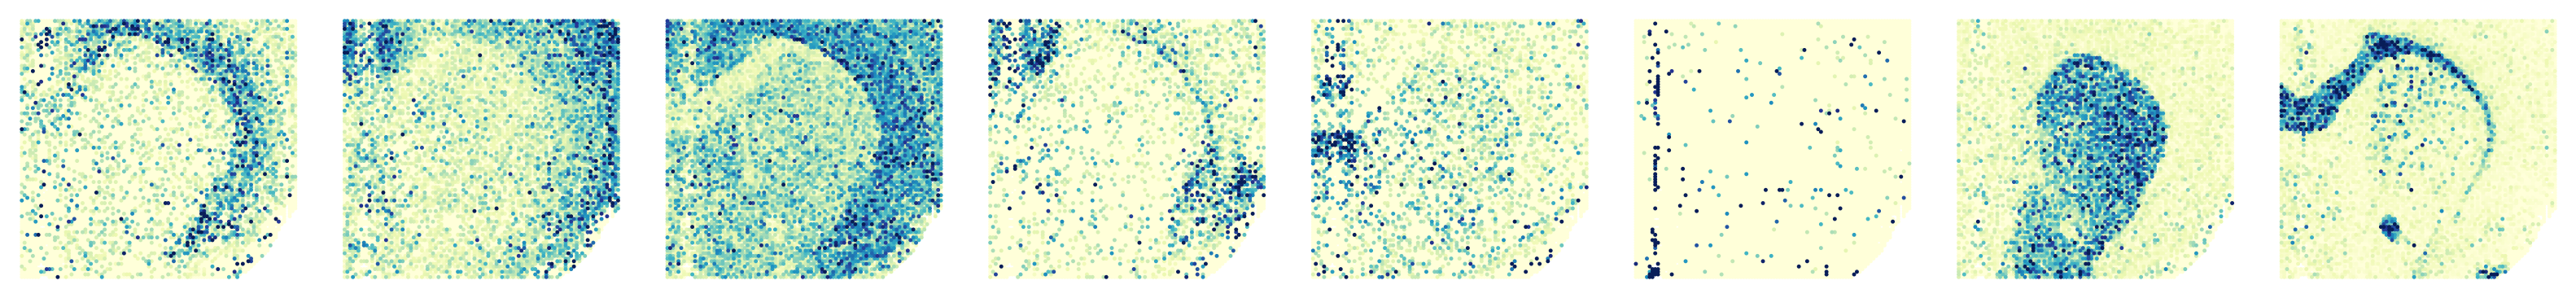

Processing slice: H3K27ac


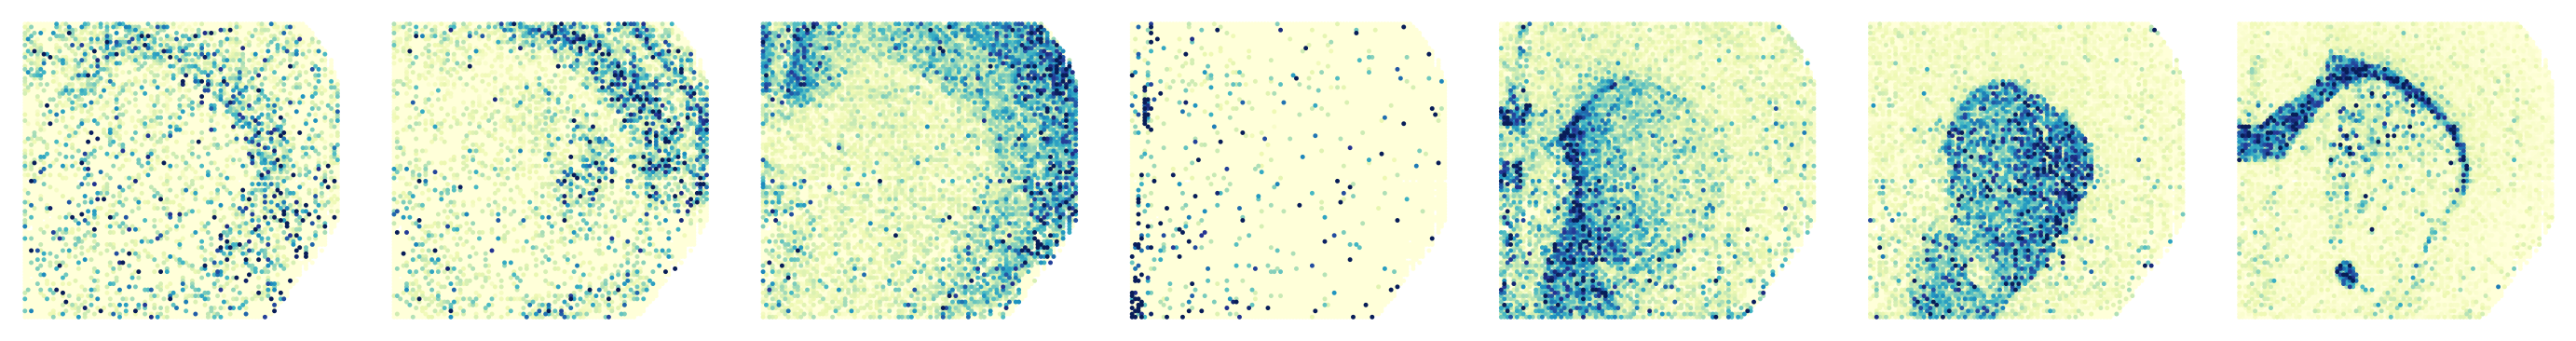

Processing slice: H3K27me3


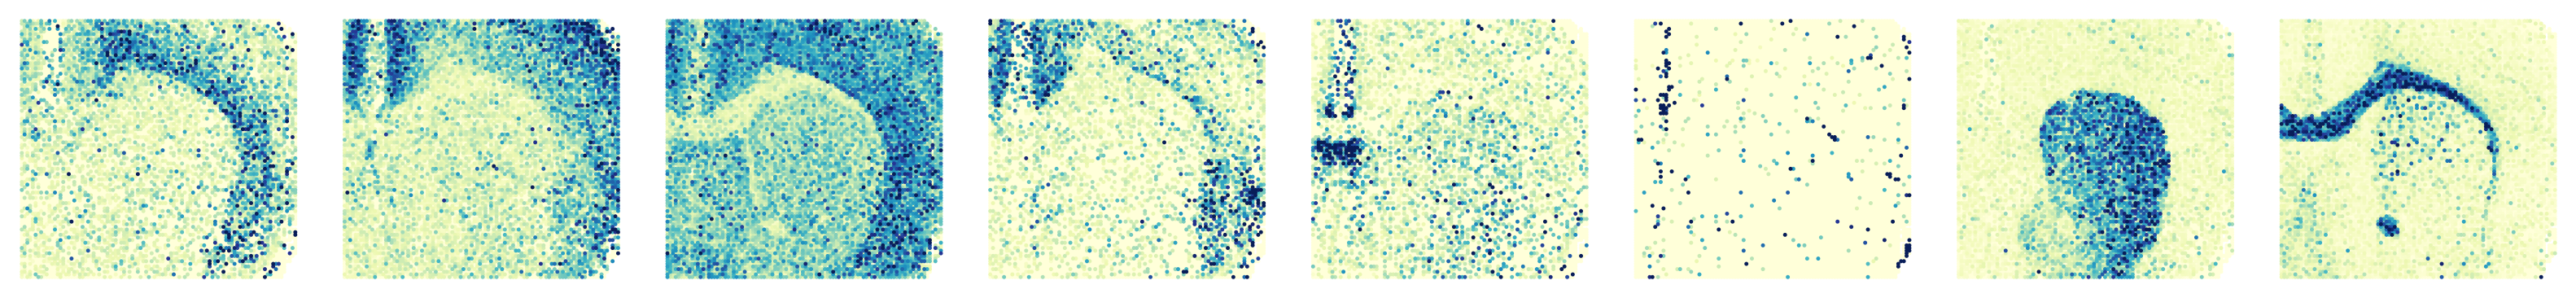

In [40]:
## Define Marker gene list
gene_list = {
    'ATAC':     ['Cpne9', 'Nr4a2', 'Myh11', 'Sox4', 'Pde10a', 'Plp1'],
    'H3K4me3':  ['X3110035E14Rik', 'Mef2c', 'Syt1', 'C1ql3', 'Wipf3', 'Myh11', 'Pde10a', 'Mobp'],
    'H3K27ac':  ['Usp46', 'Nefm', 'Mef2c', 'Col1a2', 'Zbtb20', 'Pde10a', 'Mobp'],
    'H3K27me3': ['X3110035E14Rik', 'Mef2c', 'Syt1', 'C1ql3', 'Wipf3', 'Myh11', 'Pde10a', 'Mobp']
}

for slice_id in range(0, 4):
    current_slice = slice_name[slice_id]
    print(f"Processing slice: {current_slice}")
    
    # Read data
    adata_modality_1 = sc.read_h5ad(f"../../../Data/Mouse_Brain_{current_slice}/adata_RNA.h5ad")
    
    # Data preprocessing
    sc.pp.filter_genes(adata_modality_1, min_cells=10)
    sc.pp.filter_cells(adata_modality_1, min_genes=200)
    sc.pp.highly_variable_genes(adata_modality_1, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata_modality_1, target_sum=1e4)
    
    # Get the marker genes for the current slice
    current_genes = gene_list[current_slice]
    num_genes = len(current_genes)
    
    # Set plotting parameters
    plt.rcParams['font.size'] = 18
    plt.rcParams['font.sans-serif'] = 'Arial'
    
    # Create subplots
    fig, axs = plt.subplots(1, num_genes, figsize=(num_genes * 4, 4), squeeze=False)
    
    # Determine rotation angle based on slice_id
    rotation_angle = 0
    if slice_id == 1 or slice_id == 2:  # Rotate 90 degrees clockwise for the second and third slices
        rotation_angle = 90
    elif slice_id == 3:  # Rotate 270 degrees clockwise for the fourth slice
        rotation_angle = 270
    
    if rotation_angle != 0:
        original_spatial = adata_modality_1.obsm['spatial'].copy()
        # Rotate coordinates
        adata_modality_1.obsm['spatial'] = rotate_spatial_coordinates(original_spatial, rotation_angle)

    # Iterate over each gene and plot
    for i, gene in enumerate(current_genes):
        try:
            expression = adata_modality_1[:, gene].X.toarray().flatten()
            # Replace extreme values
            adata_modality_1[:, gene].X = replace_extreme_values(expression, n=0.01)
            # Plot spatial expression
            sc.pl.embedding(adata_modality_1, basis='spatial', color=gene, ax=axs[0, i], s=50, colorbar_loc=None, show=False, cmap='YlGnBu')
            
            # Remove spines and axis labels
            for spine in axs[0, i].spines.values():
                spine.set_visible(False)
            axs[0, i].set_xlabel('')
            axs[0, i].set_ylabel('')
            axs[0, i].set_title('')
            if slice_id == 3:
                axs[0, i].invert_xaxis()
        except KeyError:
            print(f"Gene {gene} not found in {current_slice} data.")
            continue
    
    # Adjust layout
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()

    # Save figures
    plt.savefig(f'{slice_name[slice_id]}/Marker_Genes_Spatial_{slice_name[slice_id]}.png', dpi=500)
    plt.savefig(f'{slice_name[slice_id]}/Marker_Genes_Spatial_{slice_name[slice_id]}.eps')

    plt.show()

## Ploting the Marker genes' Expression

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


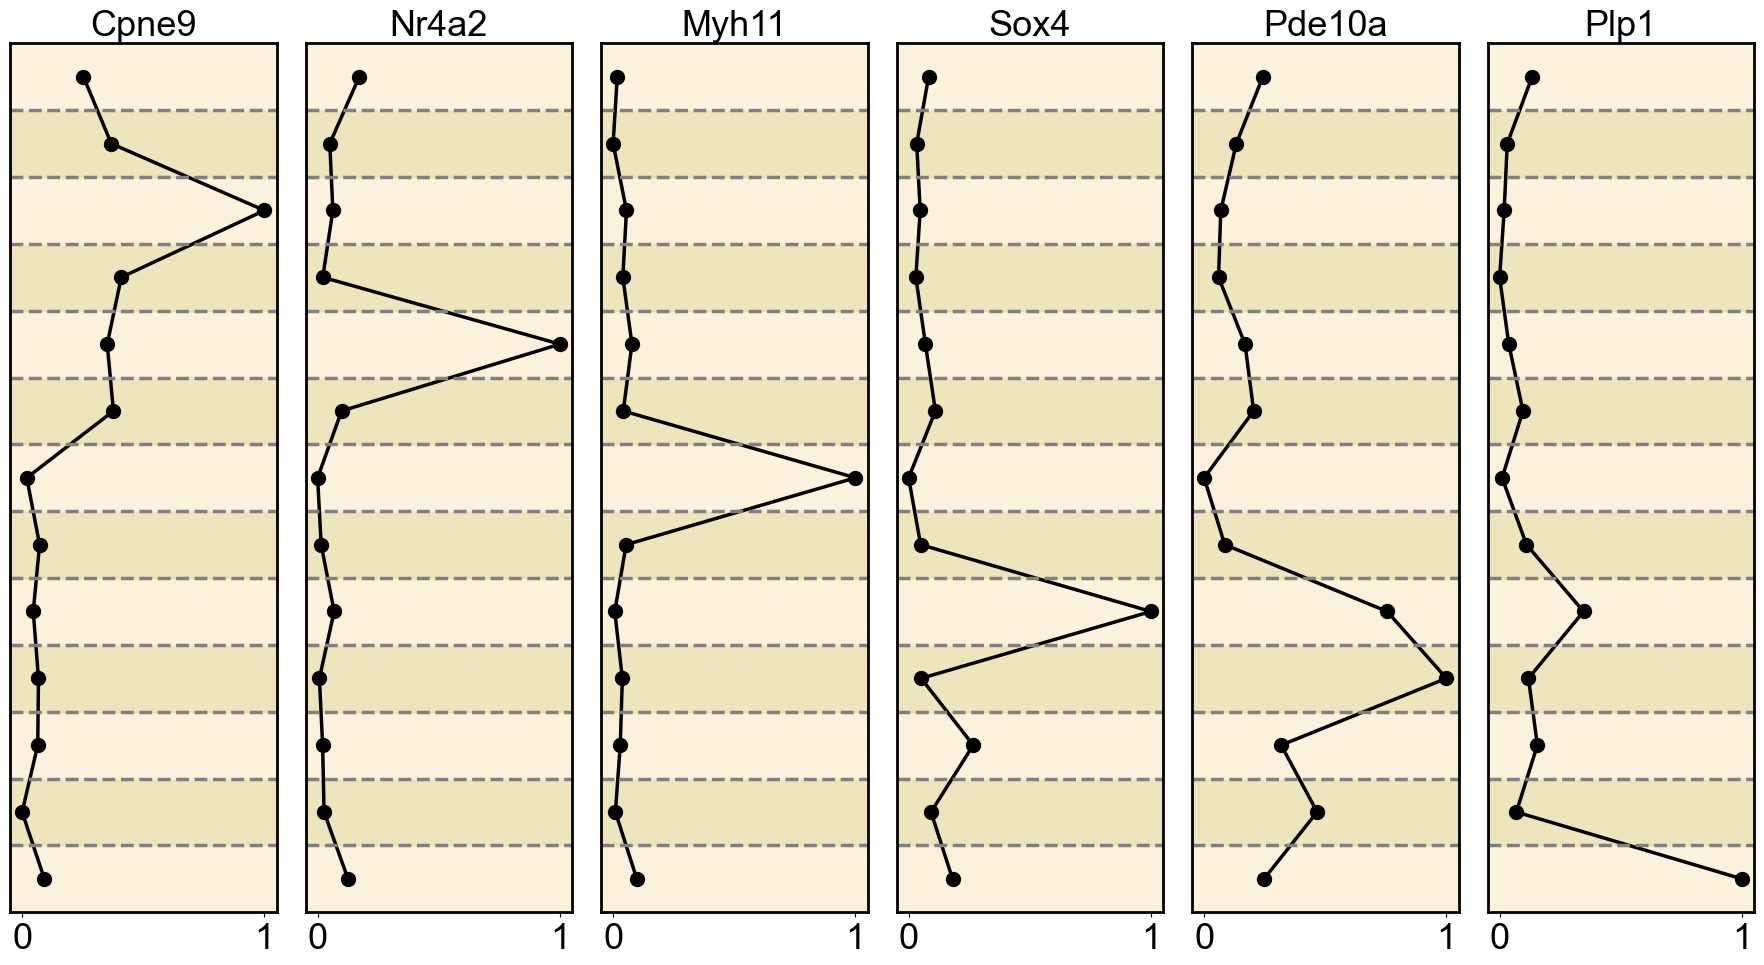

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


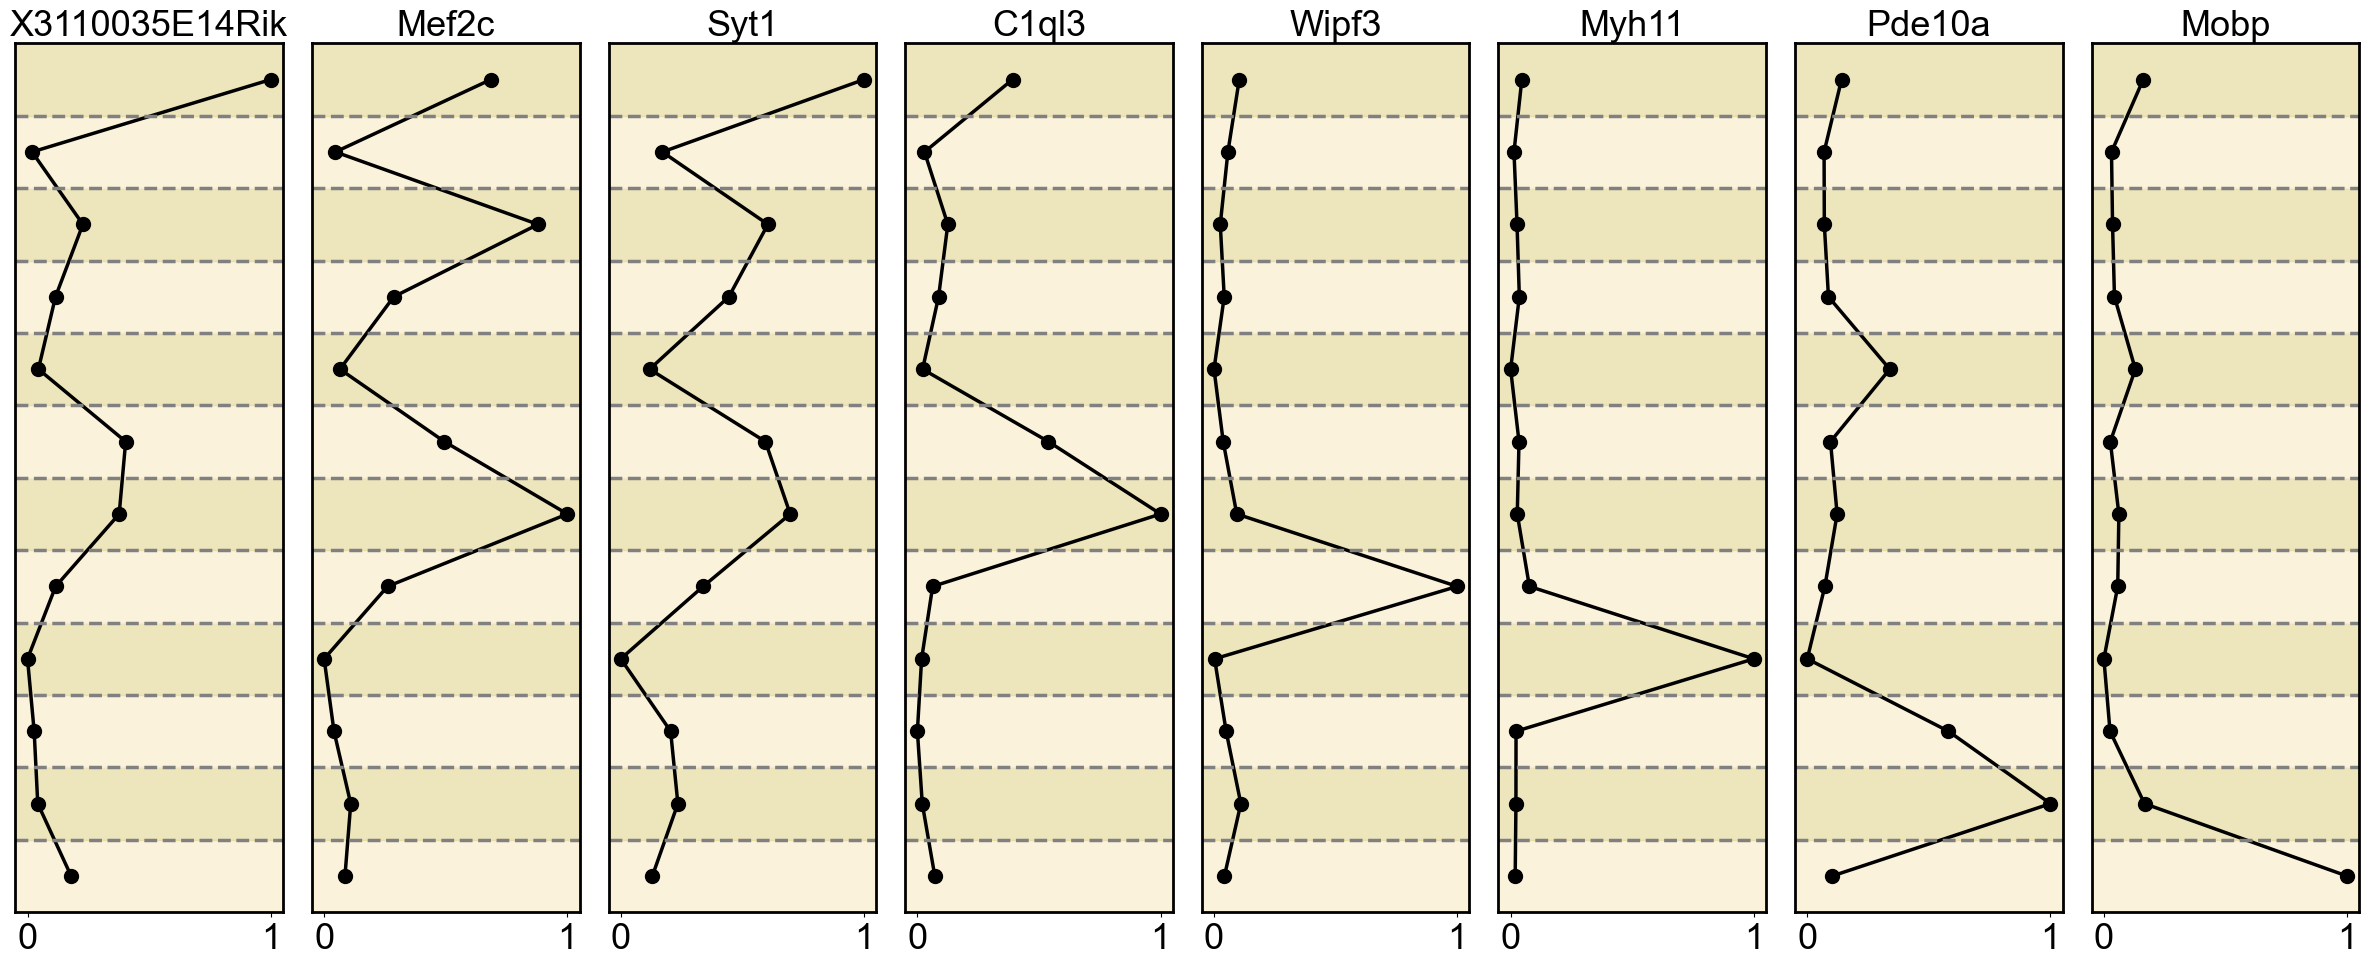

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


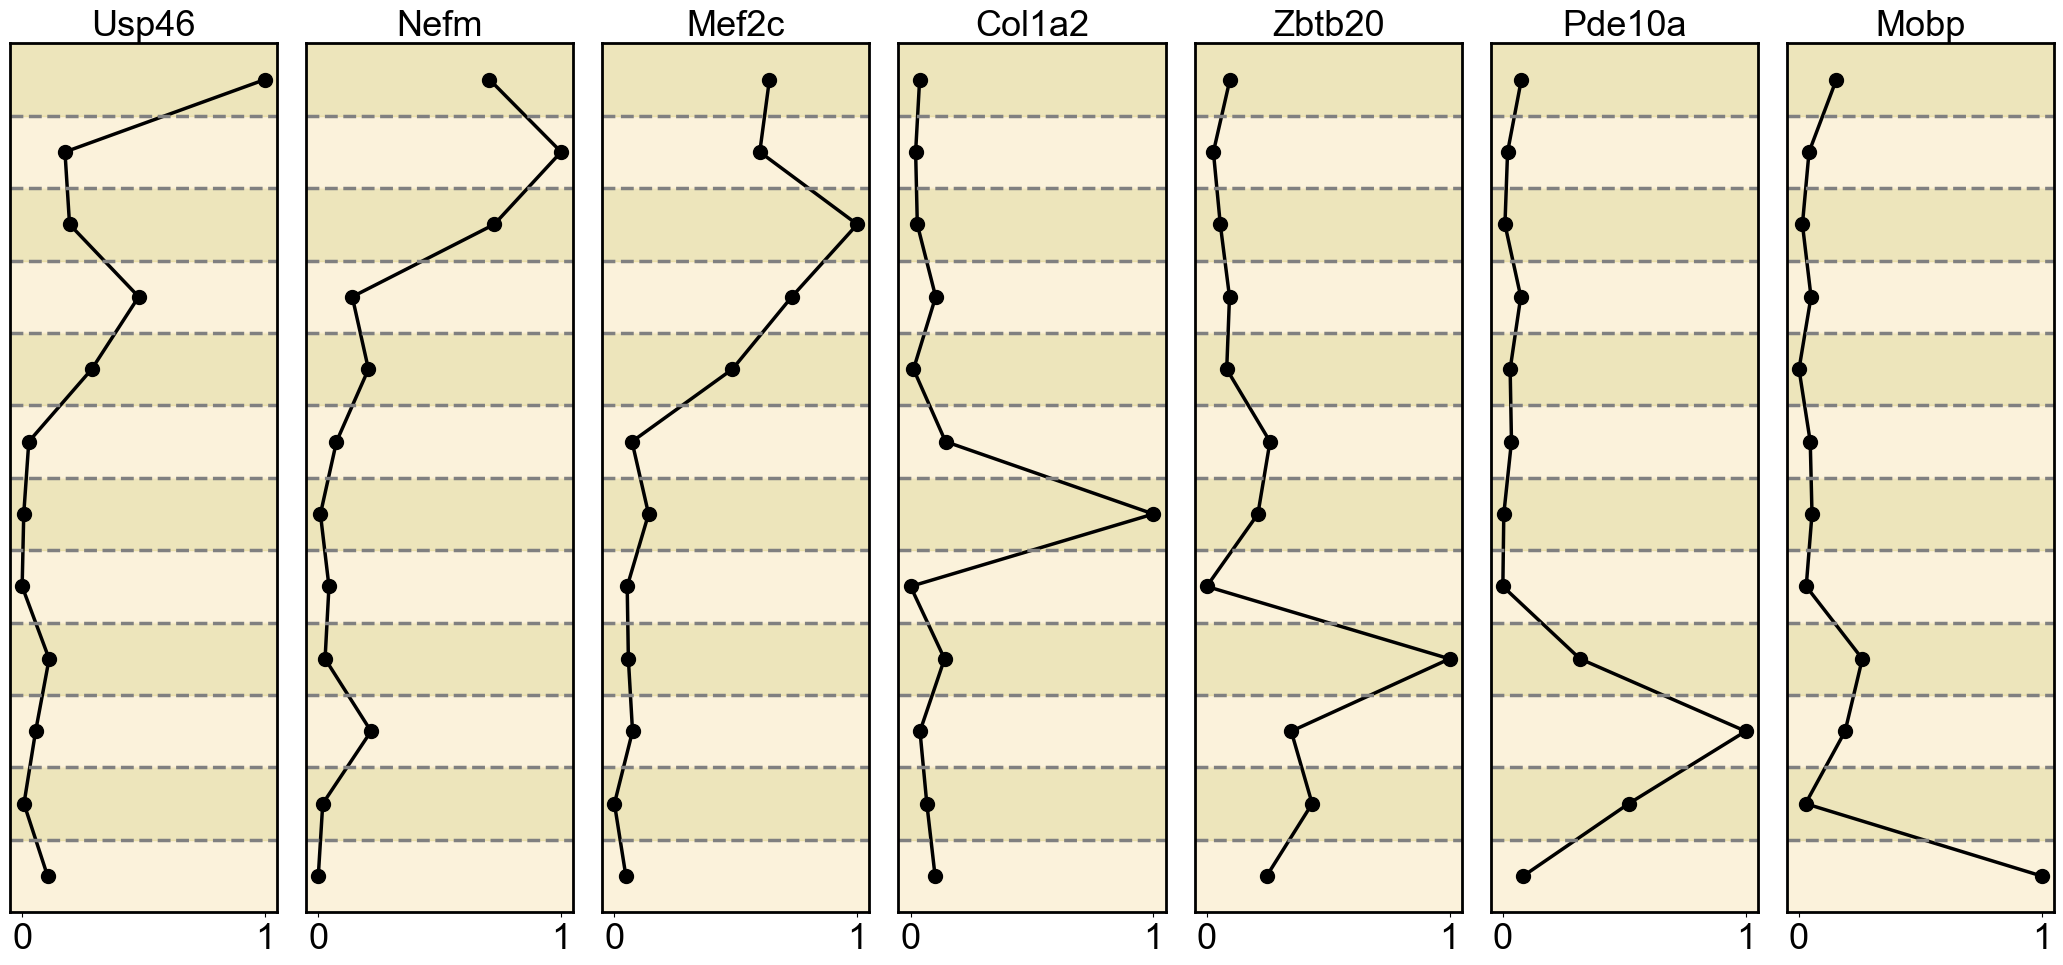

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


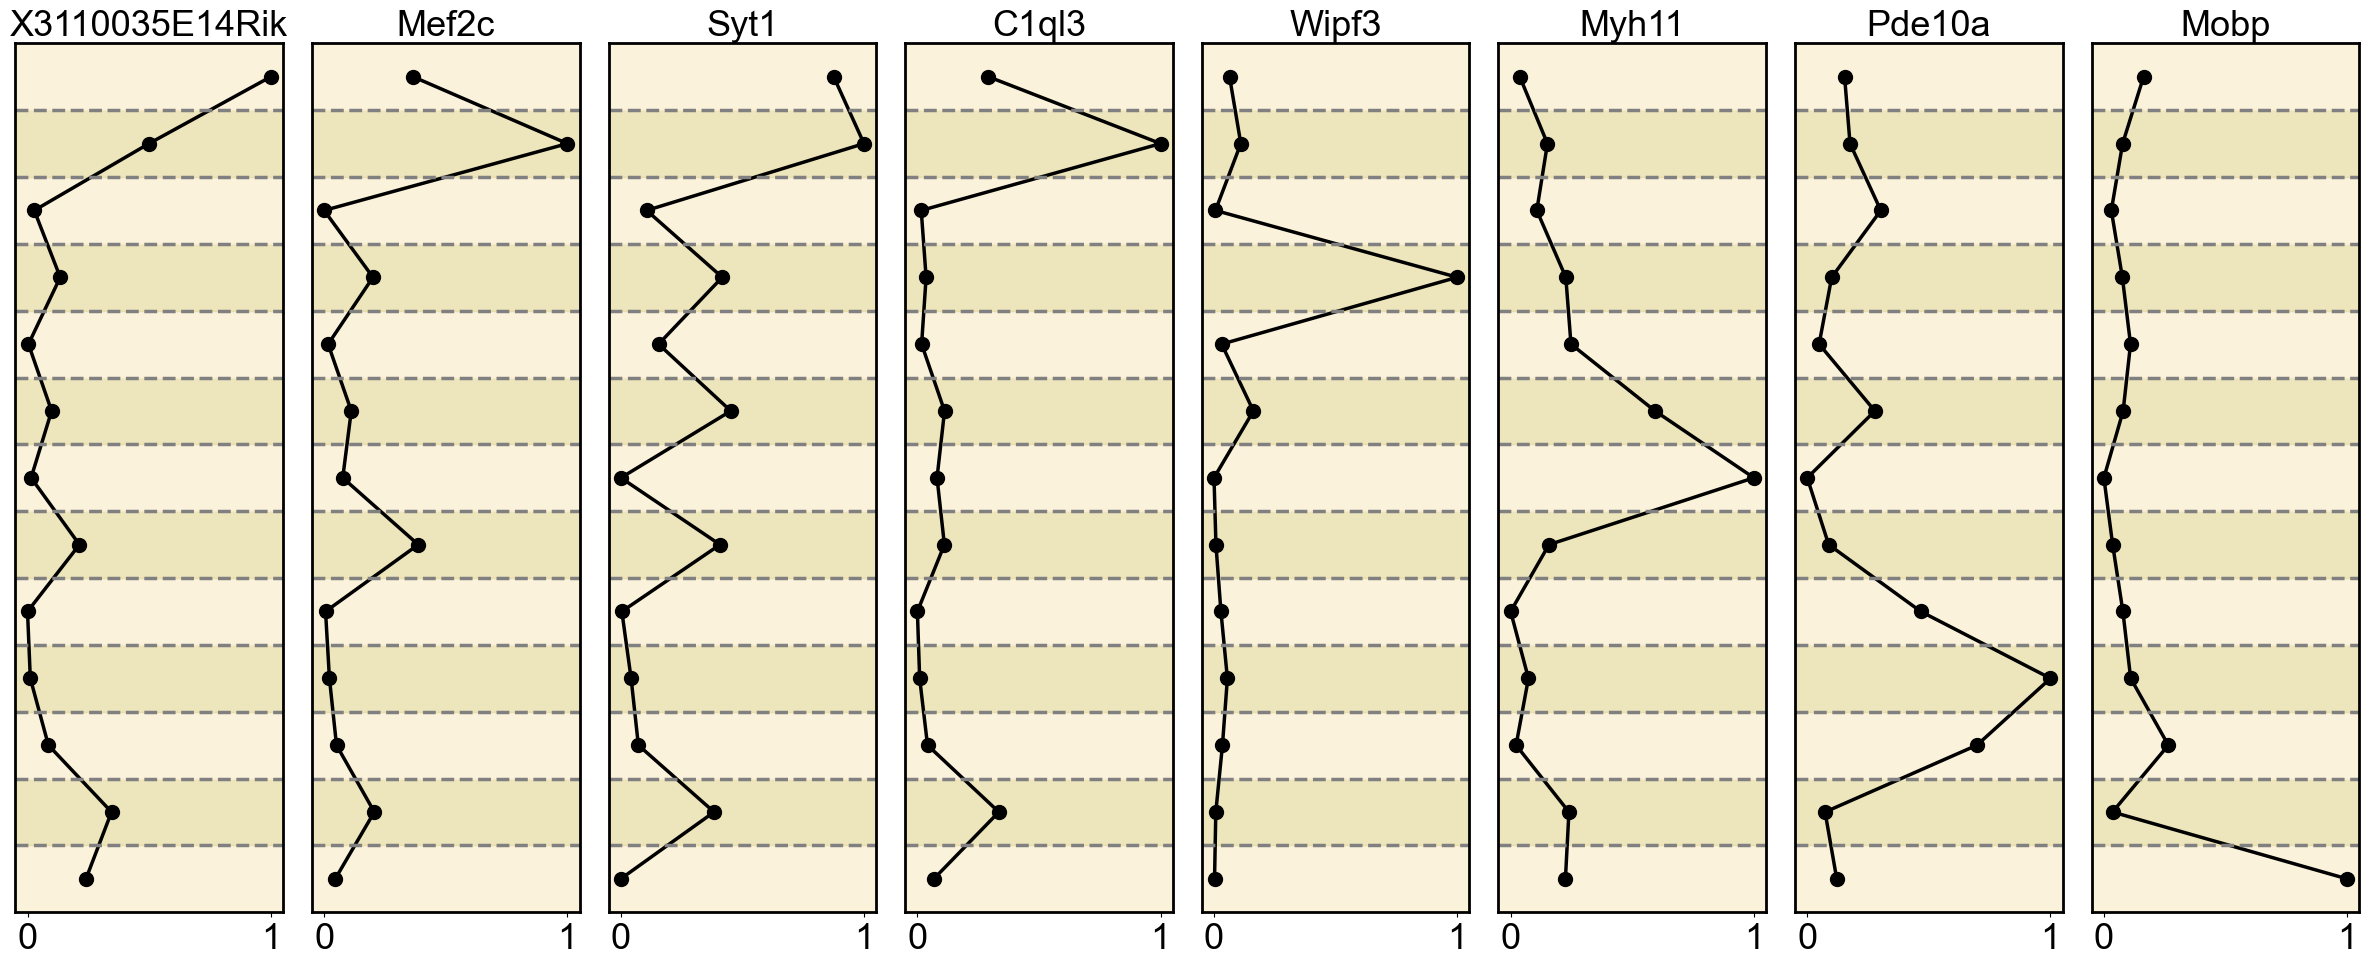

In [146]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define the new orders for each modality
new_orders = {
    'ATAC':     ["3", "2", "9", "7", "1", "10", "4", "8", "11", "0", "12", "5", "6"],
    'H3K4me3':  ["4", "2", "3", "7", "10", "5", "8", "11", "9", "1", "0", "6"],
    'H3K27ac':  ["2", "7", "3", "4", "10", "5", "9", "8", "11", "0", "1", "6"],
    'H3K27me3': ["3", "8", "9", "11", "2", "12", "4", "1", "6", "0", "10", "5", "7"]
}

# Define the colors for the background
colors = ['#faedcd', '#e6db9e']

# Iterate over each slice_id
for slice_id in range(4):
    current_slice = slice_name[slice_id]
    
    # Load the data
    adata_modality_1 = sc.read_h5ad(f"../../../Data/Mouse_Brain_{current_slice}/adata_RNA.h5ad")
    adata_results = sc.read_h5ad(f"../../Mouse_Brain_{current_slice}.h5ad")
    
    # Reorder categories
    reorder_categories(adata_results, 'SpaKnit', new_orders[current_slice])
    
    # Set the figure size and subplot layout
    fig, axes = plt.subplots(nrows=1, ncols=len(gene_list[current_slice]), figsize=(len(gene_list[current_slice]) * 3, 10))
    
    # Iterate over the gene list and create a subplot for each gene
    for i, gene in enumerate(gene_list[current_slice]):
        # Extract the expression data for the target gene
        gene_expression = adata_modality_1[:, gene].X.toarray()
        
        # Convert the expression data to a pandas Series
        gene_expression_series = pd.Series(gene_expression.flatten(), index=adata_modality_1.obs.index)
        
        # Extract cell type labels
        cell_types = adata_results.obs['SpaKnit']
        
        # Merge gene expression data and cell type labels into a DataFrame
        df = pd.DataFrame({'gene_expression': gene_expression_series, 'cell_type': cell_types})
        
        # Group by cell type and calculate the mean gene expression for each group
        mean_expression_by_cell_type = df.groupby('cell_type')['gene_expression'].mean()
        
        # Normalize the mean expression values to the range [0, 1]
        scaler = MinMaxScaler()
        normalized_expression = scaler.fit_transform(mean_expression_by_cell_type.values.reshape(-1, 1)).flatten()
        
        # Plot the normalized line chart
        ax = axes[i]  # Get the current subplot axis object
        ax.plot(normalized_expression, mean_expression_by_cell_type.index, marker='o', color='black', linewidth=2.5, markersize=10)
        ax.set_yticks([])  # Remove y-axis labels
        ax.set_ylim([-0.5, len(new_orders[current_slice])-0.5])  # Set y-axis limits
        ax.invert_yaxis()  # Invert the y-axis
        ax.set_xlim(-0.05, 1.05)  # Set x-axis limits
        ax.set_xticks([0, 1])  # Display only 0 and 1 on the x-axis
        ax.tick_params(axis='x', labelsize=26)
        
        ax.set_title(gene, fontsize=26)
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # Set the border line width to 2
        y_min, y_max = ax.get_ylim()
        num_intervals = len(new_orders[current_slice])
        y_intervals = np.linspace(y_min, y_max, num_intervals + 1)
        for j in range(num_intervals):
            lower_bound = y_intervals[j]
            upper_bound = y_intervals[j + 1]
            # Select color using modulo operation
            color = colors[j % 2]
            ax.axhspan(lower_bound, upper_bound, color=color, alpha=0.7)
            # Draw a gray dashed line at the upper boundary of each interval
            if j < num_intervals - 1:  # Avoid drawing at the upper boundary of the last interval
                ax.axhline(upper_bound, color='gray', linestyle='--', linewidth=2.5, alpha=1)
    
    plt.tight_layout()

    plt.savefig(f'{current_slice}/Marker_Gene_Expression_{current_slice}.png', dpi=500)
    plt.savefig(f'{current_slice}/Marker_Gene_Expression_{current_slice}.eps')
    plt.show()